In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [6]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [7]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [8]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [9]:
import re

def improved_clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Keep only letters, numbers and specific punctuation
    text = re.sub(r'[^a-z0-9\s!?.,]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

df['review'] = df['review'].apply(improved_clean_text)


In [10]:
from sklearn.model_selection import train_test_split

X = df['review']
y = df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,   # optional but recommended for classification
    shuffle=True  # this is True by default
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 40000
Test set size: 10000


## Tokenizer + Padding

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000       # number of words to keep
max_length = 200         # length of each input sequence

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # X_train = your training reviews

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


## label encoding

In [12]:
y_train_bin = y_train.map({'negative': 0, 'positive': 1}).values
y_test_bin = y_test.map({'negative': 0, 'positive': 1}).values


## Modelling

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 100  # size of word vectors

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # sigmoid for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=2,            # Number of epochs to wait after no improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train with the callback
history = model.fit(
    X_train_pad, y_train_bin,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=50,             # Can be large; training will stop early if needed
    callbacks=[early_stop],
    batch_size=32
)


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 283s 279ms/step - accuracy: 0.5598 - loss: 0.6681 - val_accuracy: 0.5534 - val_loss: 0.6832
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 293s 293ms/step - accuracy: 0.6164 - loss: 0.6058 - val_accuracy: 0.8418 - val_loss: 0.4013
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 287s 287ms/step - accuracy: 0.8449 - loss: 0.3826 - val_accuracy: 0.8534 - val_loss: 0.3724
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 290s 290ms/step - accuracy: 0.9024 - loss: 0.2637 - val_accuracy: 0.8715 - val_loss: 0.3166
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 291s 291ms/step - accuracy: 0.9293 - loss: 0.2055 - val_accuracy: 0.8840 - val_loss: 0.2963
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 284s 284ms/step - accuracy: 0.9502 - loss: 0.1524 - val_accuracy: 0.8794 - val_loss: 0.3252
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 289s 289ms/step - accuracy: 0.9667 - loss: 0.1083 - val_accuracy: 0.8769 - val_loss: 0.3496


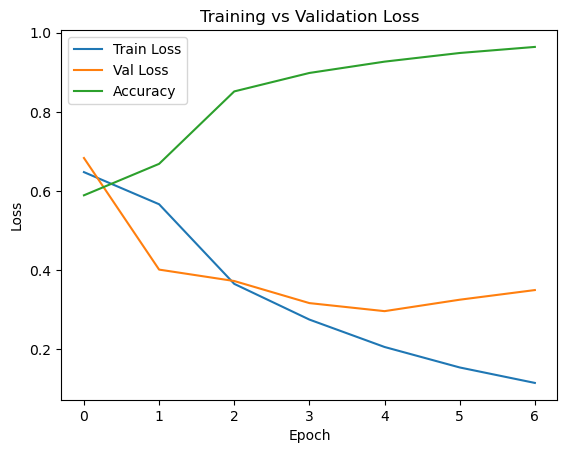

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['accuracy'], label='Accuracy')

plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [24]:
loss, accuracy = model.evaluate(X_test_pad, y_test_bin)
print(f"Test Accuracy: {accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8839 - loss: 0.2997
Test Accuracy: 0.8853


In [25]:
test_review = ["This movie was amazing and touching, though it had some flaws."]
test_seq = tokenizer.texts_to_sequences(test_review)
test_pad = pad_sequences(test_seq, maxlen=max_length, padding='post')

prediction = model.predict(test_pad)
print("Sentiment:", "positive" if prediction[0][0] > 0.5 else "negative")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Sentiment: positive


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5000
           1       0.91      0.86      0.88      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



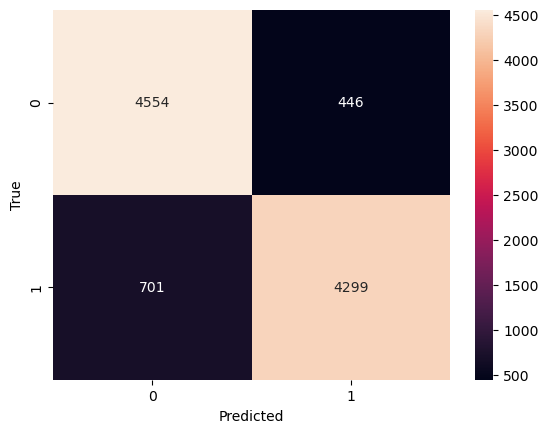

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test_bin, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
